## Download and Format Images 

Decide below which "concepts" to include. These are the classes you want to be able to identify.

In [4]:
concepts_to_include = [
    "Asteroidea",
    "Ophiuroidea",
]

Now we can use this lits to install all of this as training data from the fathomnet api

In [5]:
# Download the images from the fathomnet database
import os

data_directory = os.path.join('datasets', 'sea_data')

# !fathomnet-generate -c '{', '.join(concepts_to_include)}' \
#     --format voc \
#     --img-download "{os.path.join(data_directory, 'images')}" \
#     --output "{os.path.join(data_directory, 'labels')}"

Let's take a look at a sample of these images and with their bounding boxes

In [124]:
import xml.etree.ElementTree as ET

def parseXml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bbox_pair = []

    for obj in root.findall('object'):
        name_key = obj.find('name').text
    
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        bbox_pair.append((name_key, (xmin, ymin, xmax, ymax)))
    
    return bbox_pair

In [139]:
import cv2
from IPython.display import Image, display

def draw_boxes(image, bboxes):

    print(bboxes)
    
    for label, (x1, y1, x2, y2) in bboxes:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    display(Image(data=cv2.imencode('.jpg', image_rgb)[1].tobytes()))

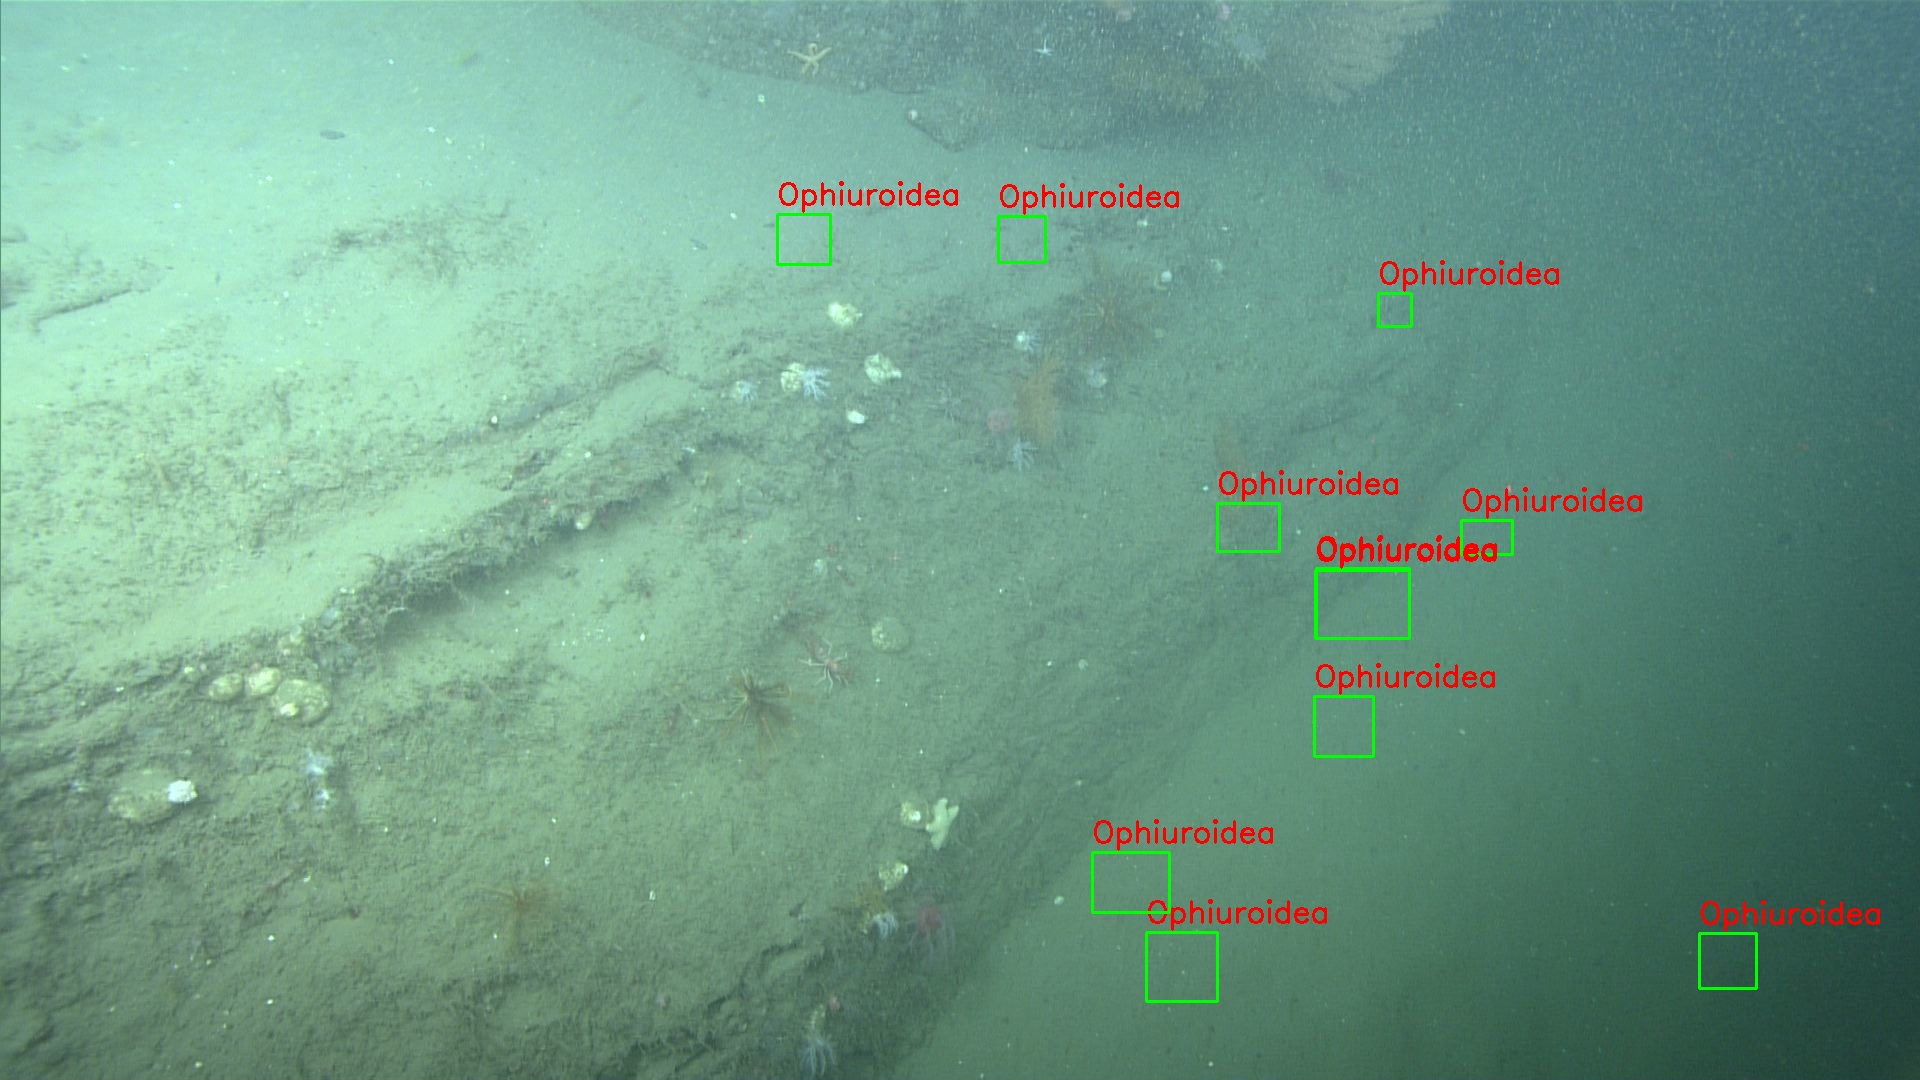

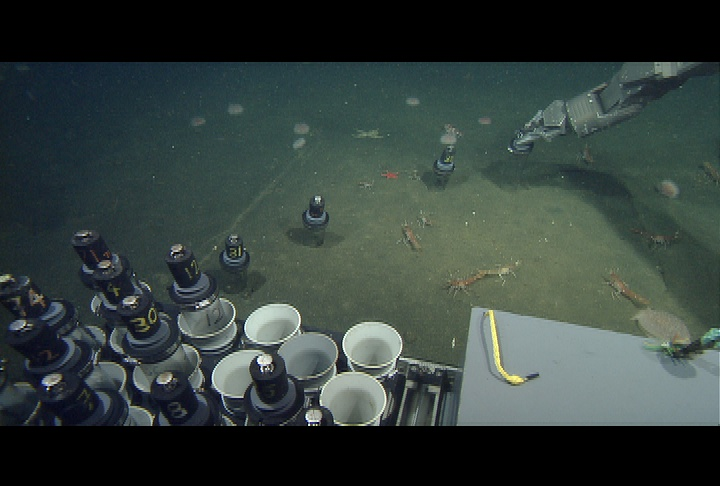

In [126]:
import os
import numpy as np

number_to_choose = 2
random_seed = 80
np.random.seed(random_seed)

image_dir = os.path.join(data_directory, 'images')
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]


random_images = np.random.choice(image_files, number_to_choose, replace=False)

for name in random_images:
    uid, _ = os.path.splitext(name)

    image_path = os.path.join(image_dir, name)
    image = cv2.imread(image_path)
    bboxes = parseXml(os.path.join(data_directory, 'labels', f"{uid}.xml"))
    
    drawBoxes(image, bboxes)

### Move Images for training

In [91]:
!pip install pyyaml
import yaml

train_dir = 'train'
val_dir = 'train'
test_dir = 'train'

def createYamlFile(yaml_name='data'):
    data = {
        "path": 'sea_data',
        "train": [os.path.join('images', train_dir)],
        "val": [os.path.join('images', val_dir)],
        "test": [os.path.join('images', test_dir)],
        "names": {str(idx): class_name for idx, class_name in enumerate(concepts_to_include)}
    }

    with open(os.path.join(data_directory, f"{yaml_name}.yaml"), "w") as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

createYamlFile()

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [92]:
import shutil

def renameAndMoveImgPair(uid, new_id, dest_dir=train_dir):
    curr_location = os.path.join(data_directory, 'images')
    src_file = os.path.join(curr_location, f"{uid}.png")

    file_exists = os.path.isfile(os.path.join(curr_location, f"{uid}.png"))
    if not file_exists: return

    os.makedirs(os.path.join(curr_location, dest_dir), exist_ok=True)
    dest_file = os.path.join(curr_location, dest_dir, f"{new_id}.png")

    shutil.move(src_file, dest_file)


# renameAndMoveImgPair('0a1ee4e2-f85f-45ac-8cc6-1ce9299c6444', '001', train_dir)

In [93]:
import xml.etree.ElementTree as ET
import cv2

def createTxtFile(uid, new_id, dest_dir=train_dir):
    curr_location = os.path.join(data_directory, 'labels')
    
    tree = ET.parse(os.path.join(curr_location, f'{uid}.xml'))
    root = tree.getroot()

    file_destination = os.path.join(curr_location, dest_dir)
    os.makedirs(file_destination, exist_ok=True)

    image = cv2.imread(os.path.join(data_directory, 'images', dest_dir, f"{new_id}.png"))
    img_height, img_width, _ = image.shape

    with open(os.path.join(file_destination, f'{new_id}.txt'), 'w') as txt_file:
        for obj in root.findall('.//object'):
            name_key = concepts_to_include.index(obj.find('name').text)
    
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            width = int(obj.find('bndbox/xmax').text) - xmin
            height = int(obj.find('bndbox/ymax').text) - ymin
    
            line = f"{name_key} {xmin / img_width:6f} {ymin / img_height:6f} {width / img_width:6f} {height / img_height:6f}"
            txt_file.write(line + '\n')

    os.remove(os.path.join(curr_location, f'{uid}.xml'))

# createTxtFile('0a1ee4e2-f85f-45ac-8cc6-1ce9299c6444', '001', train_dir)

In [94]:
directory_path = os.path.join(data_directory, 'images')

# Iterate through each file in the directory
for i, filename in enumerate(os.listdir(directory_path)):
    if not os.path.isfile(os.path.join(directory_path, filename)): 
        continue

    root_name, _ = os.path.splitext(filename)
    
    renameAndMoveImgPair(root_name, "{:012d}".format(i+1))
    createTxtFile(root_name, "{:012d}".format(i+1))
 

### Image Samples

In [146]:
def parseTxt(text_path, image_size):
    h, w, _ = image_size
    bbox_pair = []

    with open(text_path, 'r') as file:
        for line in file:
            parts = line.strip().split()

            label = concepts_to_include[int(parts[0])]
            x1, y1, bw, bh = map(float, parts[1:])
            adjusted_boxes = (x1*w, y1*h, (x1+bw)*w, (y1+bh)*h)
            bbox_pair.append((label, tuple(int(x) for x in adjusted_boxes)
))

    return bbox_pair

[('Asteroidea', (228, 230, 283, 272))]


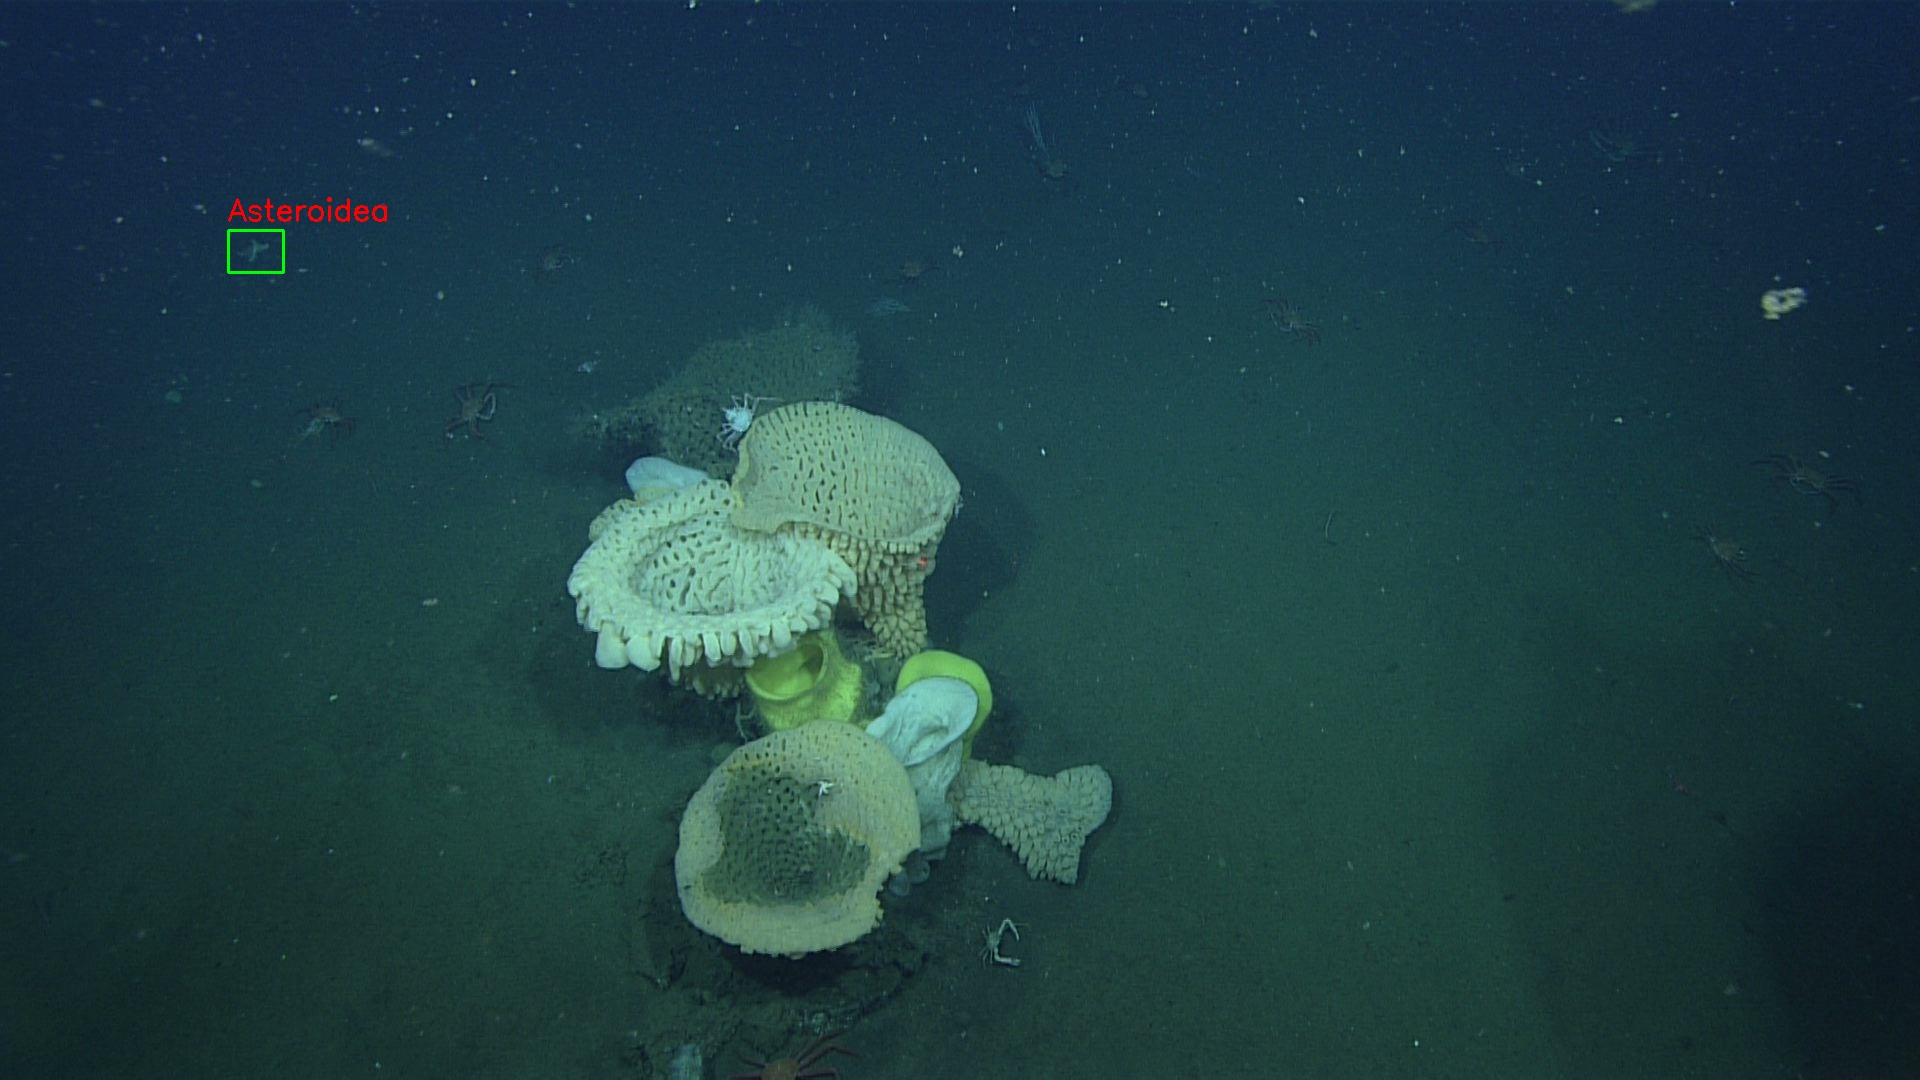

[('Asteroidea', (715, 722, 754, 760))]


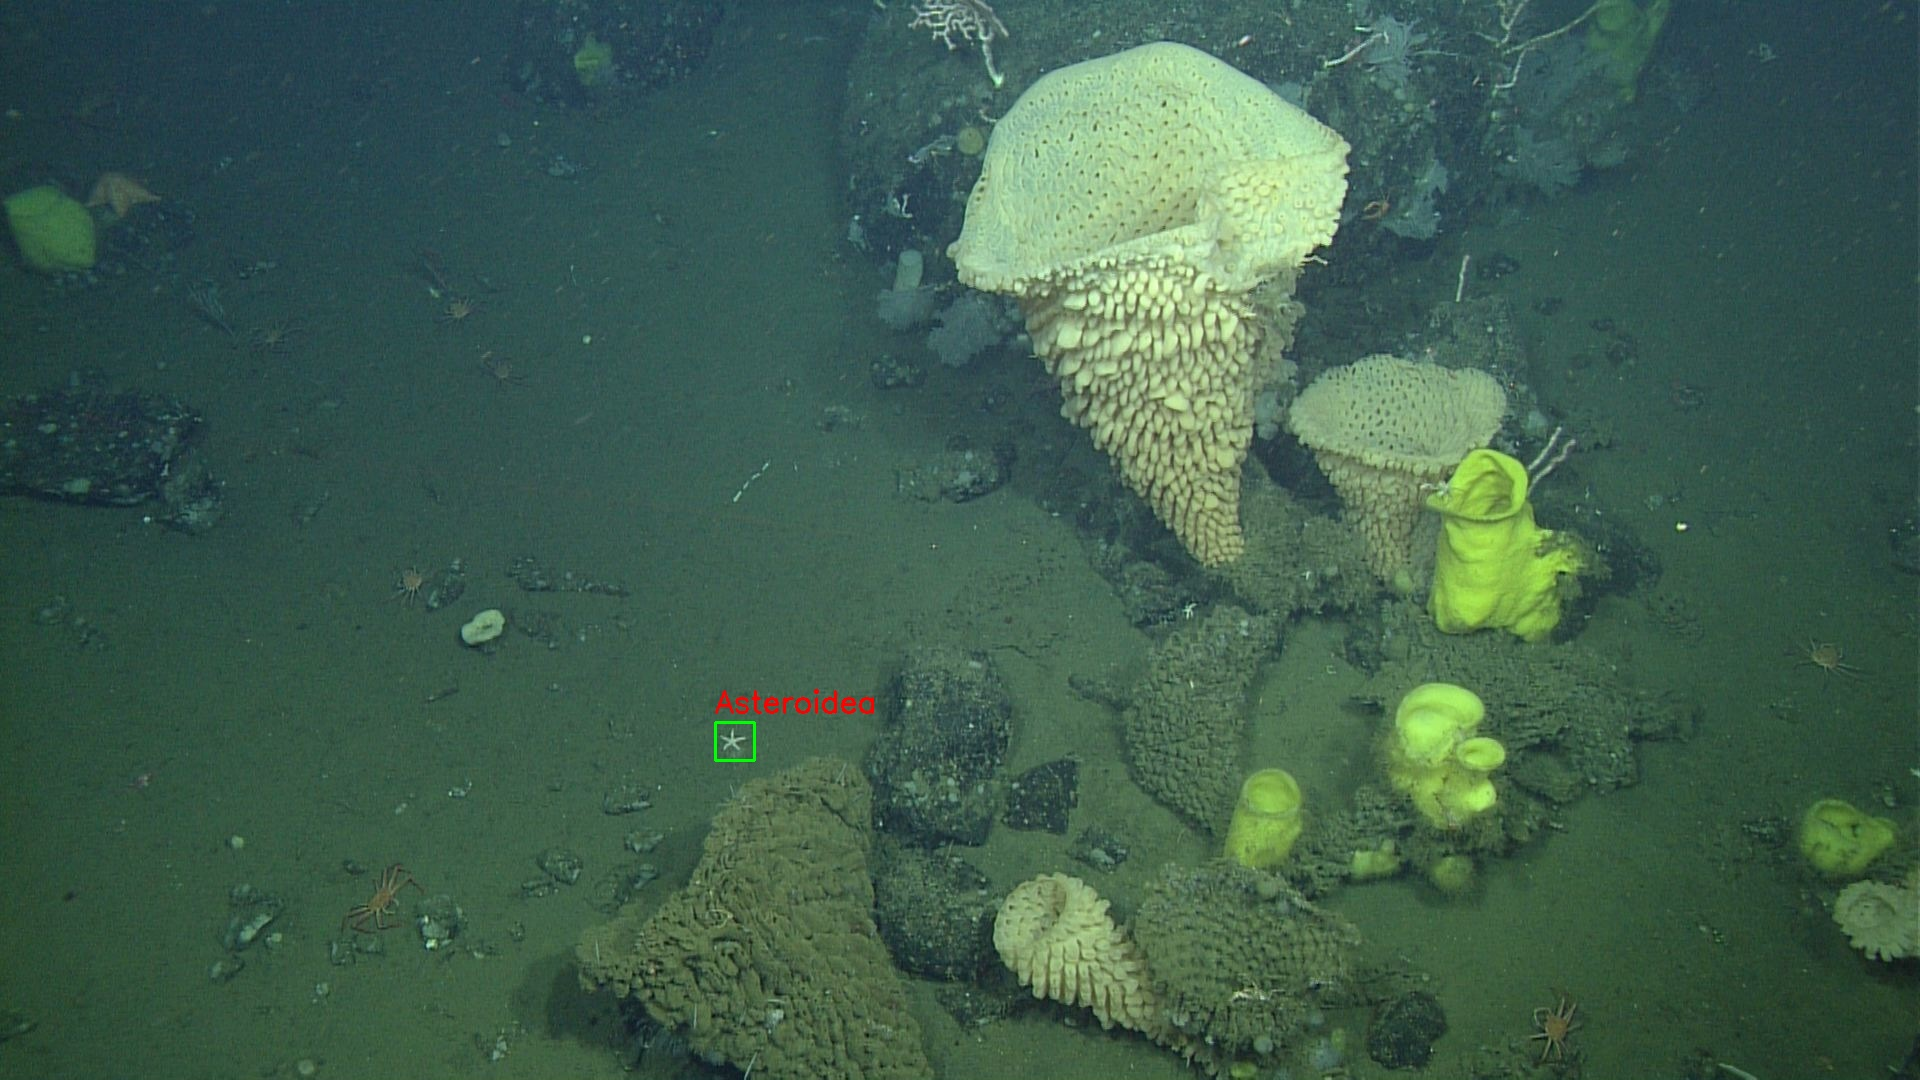

In [148]:
## Sample images for training here
import os
import numpy as np

number_to_choose = 2

image_dir = os.path.join(data_directory, 'images', train_dir)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

random_images = np.random.choice(image_files, number_to_choose, replace=False)

for name in random_images:
    uid, png = os.path.splitext(name)

    image_path = os.path.join(image_dir, name)
    image = cv2.imread(image_path)
    bboxes = parseTxt(os.path.join(data_directory, 'labels', train_dir, f"{uid}.txt"), image.shape)

    print(bboxes)
    
    drawBoxes(image, bboxes)

## Create Model and begin training

In [149]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [152]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml') 
model = YOLO('yolov8n.pt') 
model = YOLO('yolov8n.yaml').load('yolov8n.pt')

# Train the model
results = model.train(data=f"{data_directory}/data.yaml", epochs=5)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128


0: 512x736 3 Asteroideas, 2.3ms
Speed: 1.4ms preprocess, 2.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 736)
Results saved to /home/kyle/Documents/ml_projects/ultralytics/runs/detect/predict3


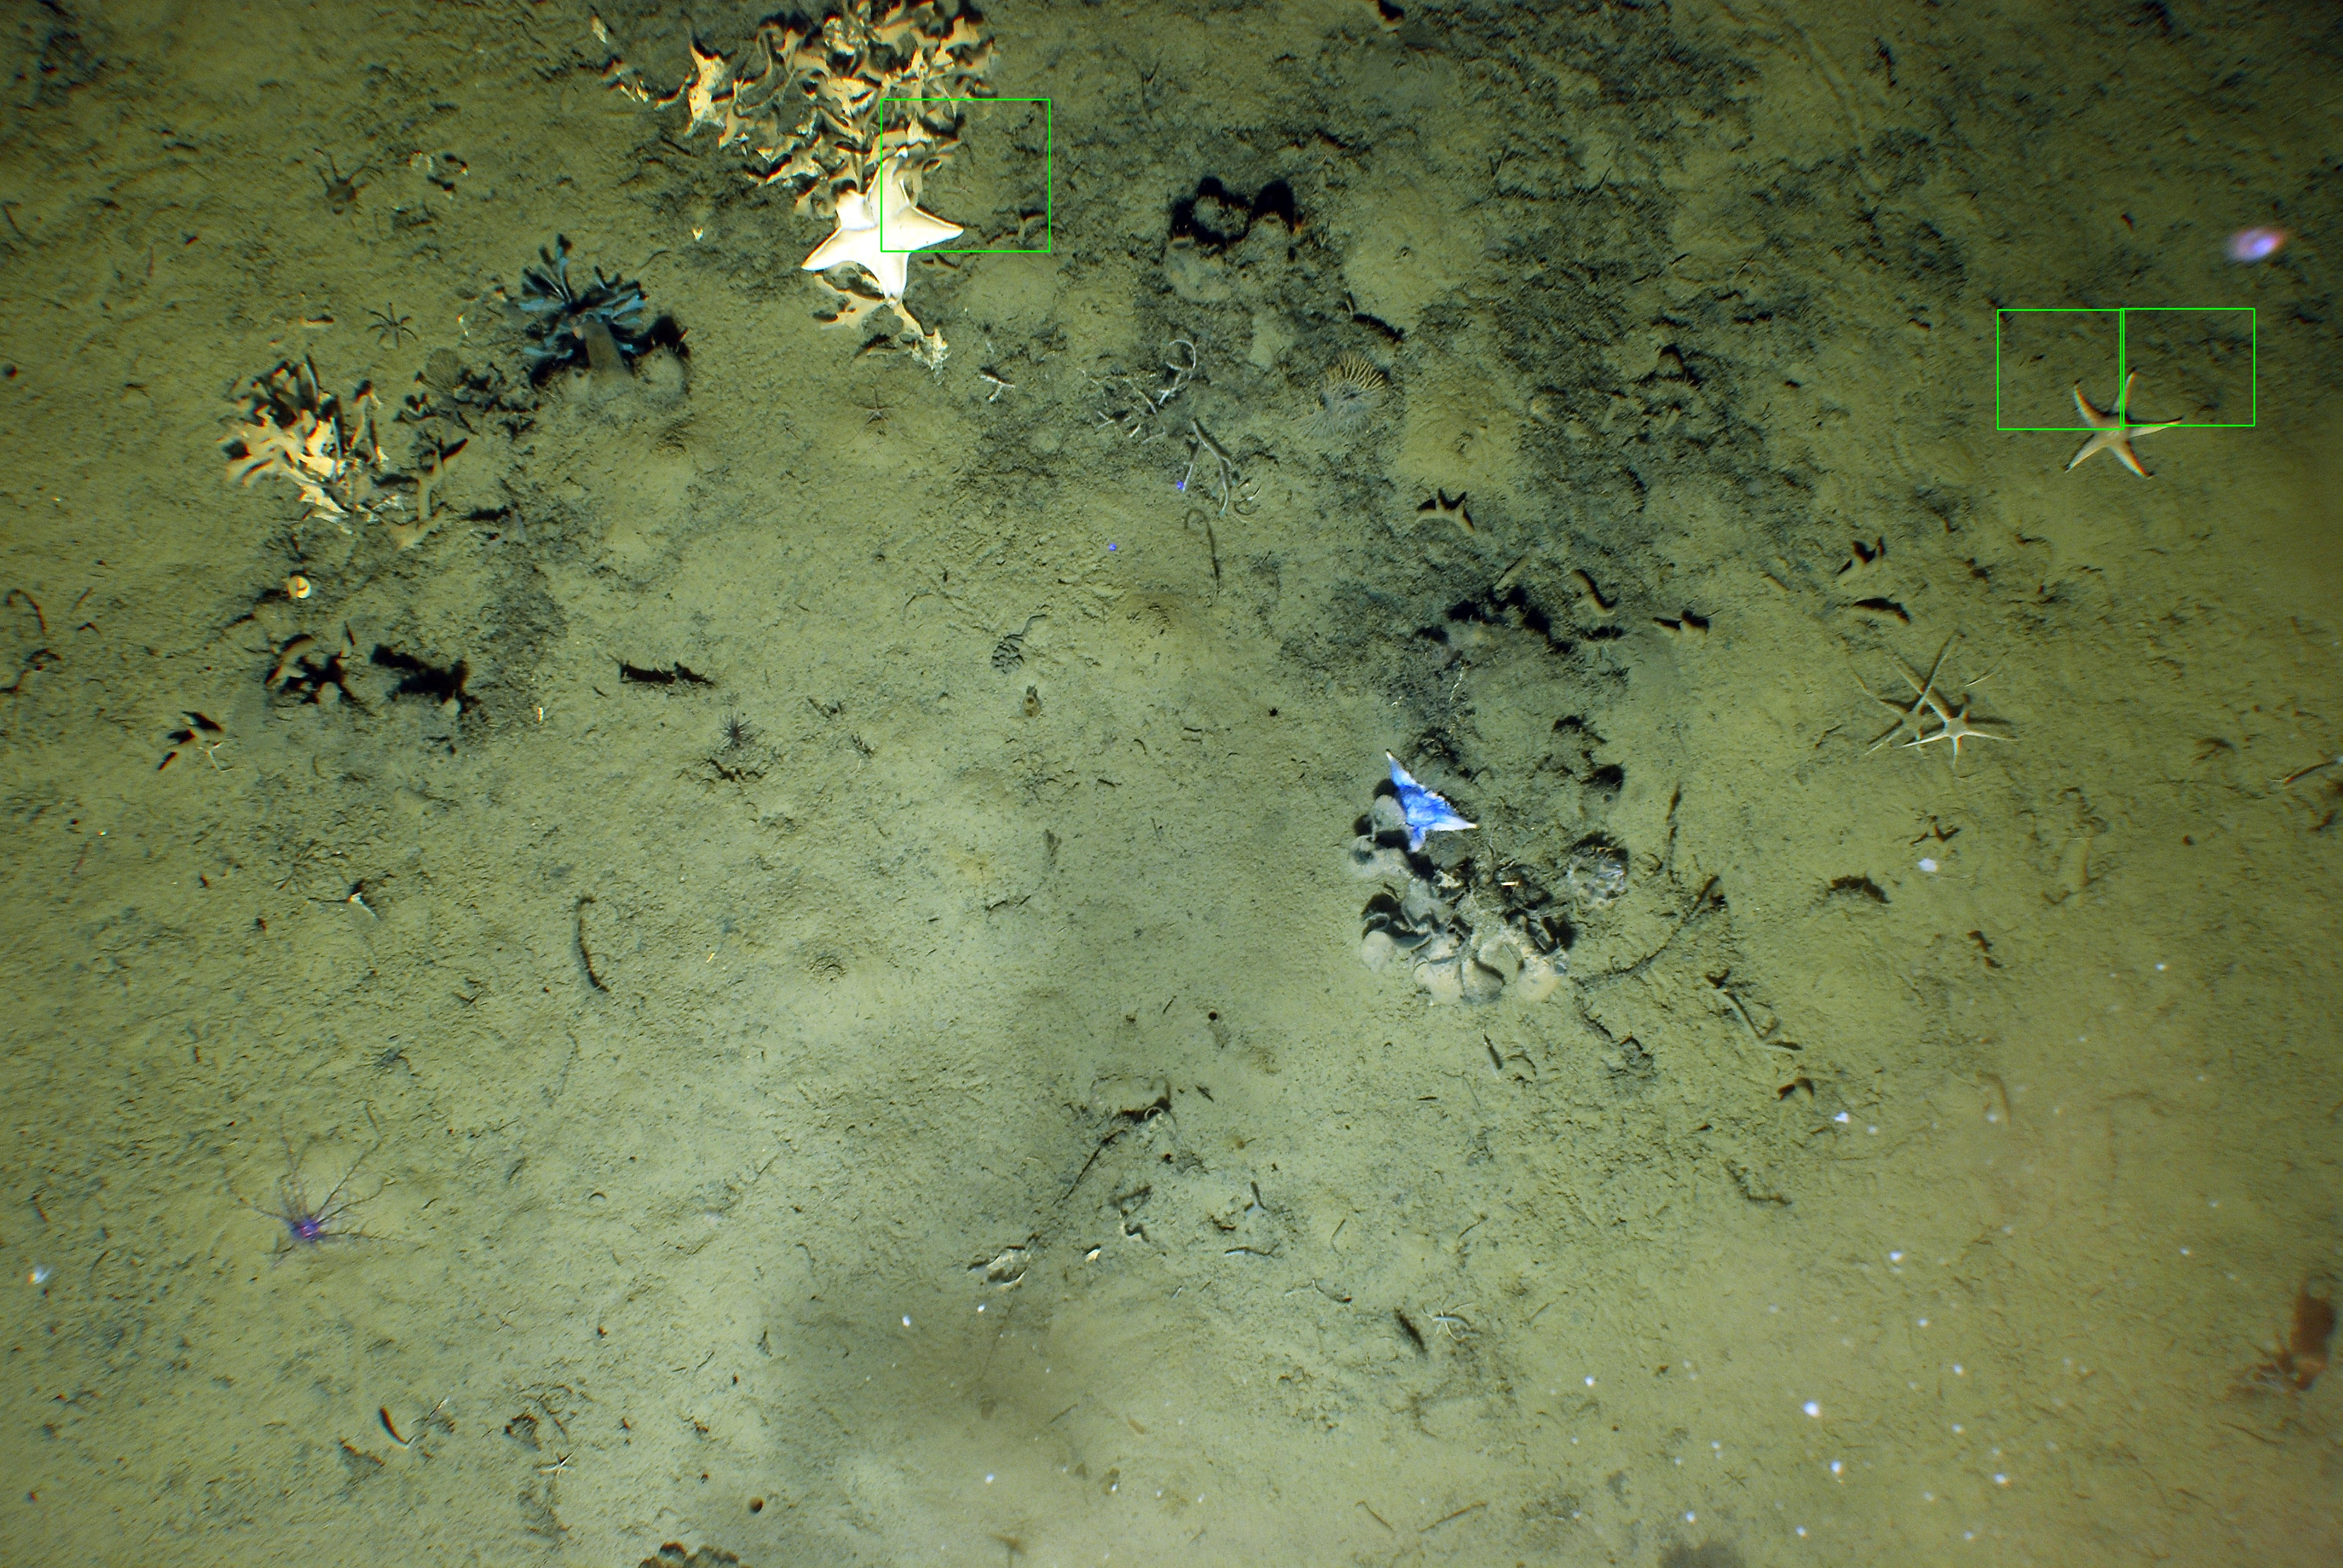

In [153]:
import cv2
from ultralytics.engine.results import Boxes
from IPython.display import display, Image

image = cv2.imread('DSC_0272.jpg')
prediction = model(image, imgsz=[512, 736], conf=0.1, save=True)

for bbox in prediction[0].boxes:
    x1, y1, x2, y2 = bbox.xyxy.cpu()[0].numpy()
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# Convert the image to RGB format for displaying in the notebook
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes in the notebook
display(Image(data=cv2.imencode('.jpg', image_rgb)[1].tobytes()))